# preprocess of recurrence

In [1]:
# 基本的なライブラリ
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# パイプライン
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from pipelines import *

# データ分割
from sklearn.model_selection import train_test_split

# スケーリング
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 次元削減
from sklearn.decomposition import PCA

import config
import functions

SEED = config.SEED
functions.fix_seed(SEED)
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
STRATIFY_NAME = "RFS_STATUS"
%matplotlib inline

/home/breast-cancer-analytics/notebooks/functions.py:196: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [3]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [4]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_clinical.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床・遺伝子データの読み込み

In [5]:
# 臨床データ
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()

# 前処理
- 目的変数生成
- 特徴量生成
- 特徴名のrename 
- 欠損値の削除


## 目的変数の生成

目的変数は再発年数（連続値）である。しかし、RFS_STATUSが0の患者は非再発であり、RFS_MONTHSは手術〜最終フォローアップの期間を示している。
そこで、非再発患者のRFS_MONTHSは0にする必要がある。

## 特徴量生成
予測の**層別化に必要な特徴を生成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

## 特徴量名のrename
重複した特徴量は別のものとして扱う


## 欠損値の削除
- 欠損値が多い→特徴量の削除  
- 欠損値が少ない→サンプルの削除

In [6]:
def generate_target():
    # RFS_STATUS, RFS_MONTHSのnullデータについては患者データを削除する
    df_MB.dropna(subset=["RFS_STATUS", "RFS_MONTHS"], inplace=True)
    # 予測ラベルを扱いやすい形に変更
    # scikit-survivalの予測モデルでは、RFS_STATUSがboolである必要がある（イベント発生がTrue, 打ち切りがFalse）
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
        {"1:Recurred": True, "0:Not Recurred": False}
    )


def generate_features():
    df_MB["NPI_CAT"] = pd.cut(
        df_MB.NPI,
        [0, 2.0, 2.4, 3.4, 5.4, np.inf],
        labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
    )
    df_MB["TUMOR_CAT"] = pd.cut(
        df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
    )
    df_MB["LYMPH_CAT"] = pd.cut(
        df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
        [-np.inf, 0, 3, np.inf],
        labels=["0", "1~3", "4~inf"],
    )


def rename_duplicatged_columns(df):
    _df = df.copy()
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename前）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )

    cols = pd.Series(_df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    _df.columns = cols
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename後）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )
    return _df


def drop_null4cols(df):
    _df = df.copy()
    print(
        "欠損値が多い特徴個数：",
        (_df.isnull().sum() > _df.shape[0] // 10).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 多数の欠損値を持つ特徴
    many_null_features = features[_df.isnull().sum() > _df.shape[0] // 10].index
    # 多数の欠損値を持つ特徴の削除
    _df.drop(many_null_features, axis=1, inplace=True)
    return _df


def drop_null4raws(df):
    _df = df.copy()
    print(
        "欠損値が少ない特徴個数：",
        ((_df.isnull().sum() < +_df.shape[0] // 10) & (_df.isnull().sum() > 0)).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 少数の欠損値を持つ特徴
    few_null_features = features[
        (_df.isnull().sum() <= _df.shape[0] // 10) & (_df.isnull().sum() > 0)
    ]
    # 少数の欠損値の遺伝子発現を持つ患者ID
    list_patient_id_contains_null_expressions = list()
    for name in few_null_features.index:
        for patient_id in _df[_df[name].isnull()].index:
            list_patient_id_contains_null_expressions.append(patient_id)

    # 少数の欠損値の遺伝子発現を持つ患者の削除
    _df.drop(list_patient_id_contains_null_expressions, inplace=True)
    return _df

重複特徴名数（rename前）： 194
重複特徴名数（rename後）： 0
欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 8


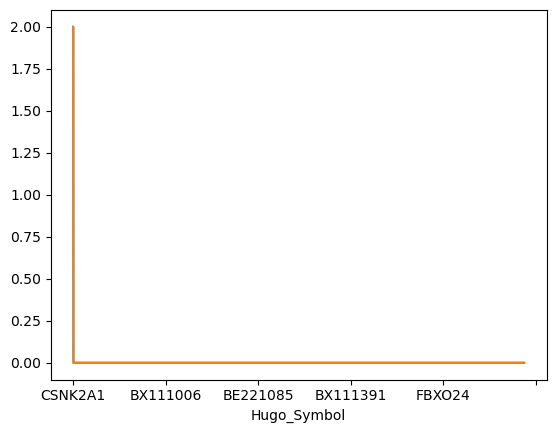

In [7]:
# 臨床データ
generate_target()
generate_features()
# 遺伝子データ
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_gene_expressions = rename_duplicatged_columns(df_gene_expressions)
df_gene_expressions = drop_null4cols(df_gene_expressions)
df_gene_expressions = drop_null4raws(df_gene_expressions)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_gene_expressions.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

**必要な特徴**

目的変数
- RFS_OVER_nMONTHS  

層別化対象候補
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全ての特徴量を結合する。

In [8]:
left_features = [
    "RFS_MONTHS",
    "RFS_STATUS",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

df_merged = pd.merge(
    df_MB[left_features],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_merged4numeric.pkl"
)
df_recurrenced = df_merged.copy()
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [9]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df, train_size: float = 0.9):
        self.__df = df.copy()
        self.__train_size = train_size

        self.__df_train = None
        self.__df_val = None
        self.__df_train_val = None
        self.__df_test = None

        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        # train & test
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[STRATIFY_NAME],
            random_state=SEED,
        )
        # train & val
        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[STRATIFY_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val(self):
        return self.__train_val.copy()

    def get_train(self):
        return self.__train.copy()

    def get_val(self):
        return self.__val.copy()

    def get_test(self):
        return self.__test.copy()

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 前処理パイプライン

In [10]:
def save_preprocessed_df(
    list_train: list(),
    list_test: list(),
    val_step: str,
    save_file_path: str = ".",
):
    """
    params
    list_train: [X_train, y_train]
    list_test: [X_test, y_test]
    """
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(list_train[0], "{0}/X.pkl".format(train_path))
    functions.pickle_dump(list_train[1], "{0}/y.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(list_test[0], "{0}/X.pkl".format(test_path))
    functions.pickle_dump(list_test[1], "{0}/y.pkl".format(test_path))


def save_preprocess_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_piepline.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(test_path))

In [11]:
def skip_preprocess(df: pd.DataFrame()) -> bool:
    """
    入力データフレームを前処理するか判断

    True: 前処理をする
    False: 前処理をしない
    """
    return True if df.shape[0] > 100 else False


def apply_preprocess(
    df: pd.DataFrame(),
    preprocess_order: dict = {"original_data": []},
    save_file_path: str = None,
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if not skip_preprocess(_df):
        return

    # データ分割
    _sp = SplitDataFrame(_df)
    _sp.split_train_val_test()
    _sp.split_X_y()

    _X_train, _y_train = _sp.get_train_Xy()
    _X_val, _y_val = _sp.get_val_Xy()
    _X_train_val, _y_train_val = _sp.get_train_val_Xy()
    _X_test, _y_test = _sp.get_test_Xy()

    # train&val と train_val&test のそれぞれのセットに適用
    dict_datasets = {
        "val_set": [[_X_train, _y_train], [_X_val, _y_val]],
        "test_set": [[_X_train_val, _y_train_val], [_X_test, _y_test]],
    }
    # 検証用、テスト用それぞれのセットへのパイプラインの適用
    for key, values in dict_datasets.items():
        # set_config(display="diagram")
        _preprocess_pipeline = Pipeline(steps=preprocess_order)
        _preprocess_pipeline.fit(values[0][0], values[0][1])
        values[0][0] = _preprocess_pipeline.transform(values[0][0])
        values[1][0] = _preprocess_pipeline.transform(values[1][0])

        print(
            "X_train: ",
            values[0][0].shape,
            " X_test: ",
            values[1][0].shape,
        )

        # 保存
        if save_file_path:
            save_preprocessed_df(
                list_train=[values[0][0], values[0][1]],
                list_test=[values[1][0], values[1][1]],
                val_step=key,
                save_file_path=save_file_path,
            )
            save_preprocess_pipeline(
                _preprocess_pipeline,
                val_step=key,
                save_file_path=save_file_path,
            )

In [12]:
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        #    "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    # 実施したい前処理パイプラインの定義
    preprocess_order_dicts = [
        {
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "preprocess_order": [
                (
                    StandardScalerAsDataFrame().__class__.__name__,
                    StandardScalerAsDataFrame(),
                ),
                (
                    PCA().__class__.__name__,
                    PCA(n_components=PCA_PERCENTILE / 100, random_state=config.SEED),
                ),
            ],
        },
    ]

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                output_file_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                )
                apply_preprocess(
                    df,
                    preprocess_order=preprocess_order_dict["preprocess_order"],
                    save_file_path=output_file_path,
                )

In [13]:
for p in range(80, 96):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_exec()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
80
claudin-low :  (197, 24370)
X_train:  (159, 95)  X_test:  (18, 95)
X_train:  (177, 105)  X_test:  (20, 105)
LumA :  (673, 24370)
X_train:  (544, 309)  X_test:  (61, 309)
X_train:  (605, 341)  X_test:  (68, 341)
LumB :  (460, 24370)
X_train:  (372, 220)  X_test:  (42, 220)
X_train:  (414, 244)  X_test:  (46, 244)
Her2 :  (218, 24370)
X_train:  (176, 108)  X_test:  (20, 108)
X_train:  (196, 119)  X_test:  (22, 119)
Normal :  (140, 24370)
X_train:  (113, 70)  X_test:  (13, 70)
X_train:  (126, 78)  X_test:  (14, 78)
Basal :  (199, 24370)
X_train:  (161, 101)  X_test:  (18, 101)
X_train:  (179, 111)  X_test:  (20, 111)
NC :  (6, 24370)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
81
claudin-low :  (197, 24370)
X_train:  (159, 98)  X_test:  (18, 98)
X_train:  (177, 108)  X_test:  (20, 108)
LumA :  (673, 24370)
X_train:  (544, 319)  X_

# recheck data shape

In [14]:
df_recurrenced.shape

(1893, 24372)

In [15]:
df_recurrenced.RFS_STATUS.value_counts()

False    1126
True      767
Name: RFS_STATUS, dtype: int64

In [16]:
df_recurrenced.groupby("CLAUDIN_SUBTYPE").RFS_STATUS.value_counts()

CLAUDIN_SUBTYPE  RFS_STATUS
Basal            False         111
                 True           88
Her2             True          113
                 False         105
LumA             False         453
                 True          220
LumB             False         240
                 True          220
NC               False           3
                 True            3
Normal           False          79
                 True           61
claudin-low      False         135
                 True           62
Name: RFS_STATUS, dtype: int64